<a href="https://colab.research.google.com/github/GodJiLee/Machine_learning_study/blob/master/11%EC%9E%A5_%EA%B5%B0%EC%A7%91%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11장. 레이블되지 않은 데이터 다루기 : 군집 분석
## 11.1 k-평균 알고리즘을 사용하여 유사한 객체를 그룹핑하기
### 11.1.1 사이킷런을 사용한 k-평균 군집

In [0]:
from sklearn.datasets import make_blobs 

# 150개의 랜덤하게 생성된 포인트 생성
X, y = make_blobs(n_samples = 150, 
                  n_features = 2, 
                  centers = 3, 
                  cluster_std = 0.5, 
                  shuffle = True, 
                  random_state = 0)

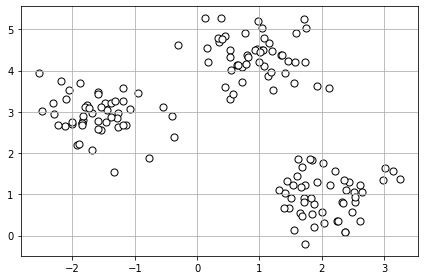

In [3]:
import matplotlib.pyplot as plt

# 2차원 산점도 그리기
plt.scatter(X[:, 0], X[:, 1], 
            c = 'white', marker = 'o', edgecolor = 'black', s = 50)
plt.grid()
plt.tight_layout()
plt.show()

# 세 개의 그룹을 형성 
# 비지도학습이므로 각 샘플에 대한 카테고리 정보는 사전에 주어지지 않음

In [0]:
from sklearn.cluster import KMeans #위에서 마련한 데이터셋에 대해 사이킷런의 KMeans 모듈 적용
km = KMeans(n_clusters = 3, #군집은 3개로 설정
            init = 'random', # K_means를 선택
            n_init = 10, # SSE를 최소화하는 센트로이드를 찾기 위해 10번 실행
            max_iter = 300,
            tol = 1e-04, 
            random_state = 0)

y_km = km.fit_predict(X) # 예측 클러스터 레이블 생성

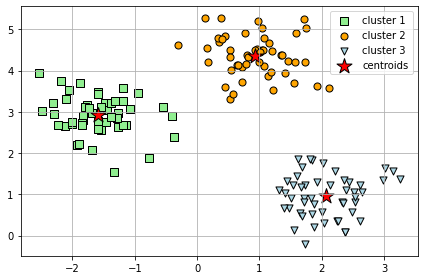

In [11]:
# 예측한 클러스터와 중심을 시각화 

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s = 50, c = 'lightgreen',
            marker = 's', edgecolor = 'black',
            label = 'cluster 1')

plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s = 50, c = 'orange',
            marker = 'o', edgecolor = 'black', 
            label = 'cluster 2')

plt.scatter(X[y_km == 2, 0], 
            X[y_km == 2, 1],
            s = 50, c = 'lightblue',
            marker = 'v', edgecolor = 'black', 
            label = 'cluster 3')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s = 250, marker = '*',
            c = 'red', edgecolor = 'black', 
            label = 'centroids')

plt.legend(scatterpoints = 1)
plt.grid()
plt.tight_layout()
plt.show()

# 이와 같은 작은 2차원 데이터셋에 대해서는 K-means가 잘 작동함 
# 하지만 군집의 개수를 사전에 지정해줘야 한다는 점과 군집 안에 적어도 하나의 샘플이 포함되어 있다는 가정이 필요하다는 등의 한계가 존재함
# 계층적 군집, 밀집도 기반 군집 등으로 이러한 한계를 극복할 수 있음 

### 11.1.4 엘보우 방법을 사용하여 최적의 클러스터 개수를 찾기

In [12]:
print('왜곡 : %.2f' % km.inertia_) # 클러스트 분류의 성능을 측정하기 위해 사이킷런 내부에 계산되어 있는 SSE 를 사용할 것임

왜곡 : 72.48


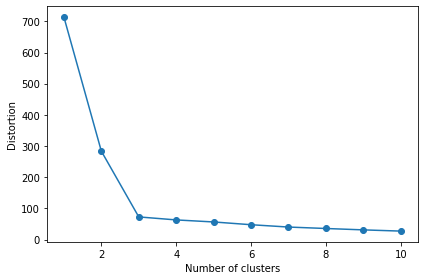

In [23]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                n_init = 10,
                max_iter = 300,
                random_state = 0)
    
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

# 기본적으로는 군집의 개수가 늘어날 수록 왜곡은 작아짐
# 왜곡이 빠르게 늘어나는(엘보우) K = 3을 최적의 군집 개수로 선택할 수 있음

### 11.1.5 실루엣 그래프로 군집 품질을 정량화하기

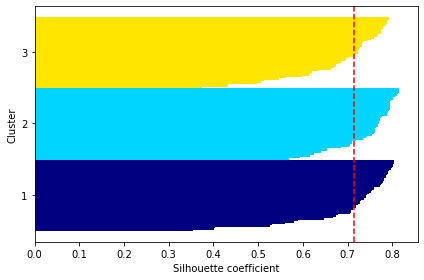

In [28]:
km = KMeans(n_clusters = 3, 
            init = 'k-means++',
            n_init = 10, 
            max_iter = 300,
            tol = 1e-04,
            random_state = 0)
y_km = km.fit_predict(X) #앞서 설정한 K-means 알고리즘을 K-means++로 바꿔줌

import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, 
                                     y_km, 
                                     metric = 'euclidean') #실루엣 계수 계산

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height = 1.0,
             edgecolor = 'none',
             color = color) # 서로 다른 군집 3개를 구분하여 시각화
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals) #모든 샘플에 대해 평균 실루엣 계수를 계산

plt.axvline(silhouette_avg,
            color = 'red',
            linestyle = '--')

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

# 클러스터 크기 = 3, 실루엣 계수값이 0에서 멀리 떨어져 있음 
# 군집간 차이와 군집내 유사도가 큰 적절한 군집화가 이루어짐

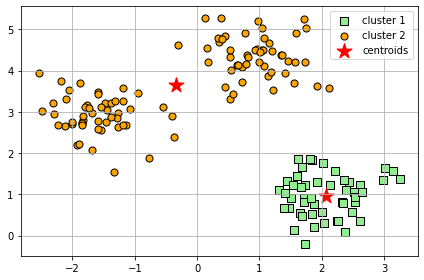

In [39]:
# 잘못된 클러스터링
# 중심은 2개로 설정

km = KMeans(n_clusters = 2,
            init = 'k-means++',
            n_init = 10,
            max_iter = 300,
            tol = 1e-04,
            random_state = 0)

y_km = km.fit_predict(X)

plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s = 50, c = 'lightgreen',
            edgecolor = 'black',
            marker = 's',
            label = 'cluster 1')

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s = 50, 
            c = 'orange',
            edgecolor = 'black',
            marker = 'o',
            label = 'cluster 2')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s = 250, 
            marker = '*',
            c = 'red',
            label = 'centroids')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 하나의 중심이 두 군집 중간에 놓여 있음

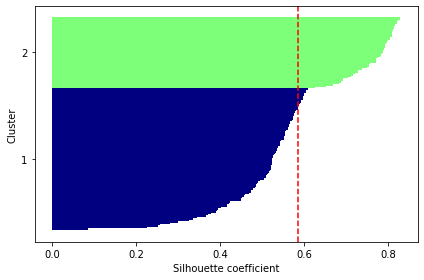

In [41]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, 
                                     y_km,
                                     metric = 'euclidean') #유클리디안 거리로 실루엣 계수 계산

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height = 1.0,
             edgecolor = 'none',
             color = color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals) # 실루엣 계수 두 군집에 대해 시각화

silhouette_avg = np.mean(silhouette_vals) # 모든 샘플에 대한 실루엣 계수의 평균을 계산하여 전체적인 성능을 요약
plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

# 이전 실루엣 그래프에 비해 두께와 길이 면에서 이전에 비해 성능이 더 안 좋은 것을 알 수 있음
# 파란색 군집이 실루엣 계수가 비교적 작은 것으로 보아 집단적 분류강도가 더 약한 것을 알 수 있음

## 11.2 계층적인 트리로 클러스터를 조직화하기
### 11.2.1 상향식으로 클러스터 묶기

In [42]:
import pandas as pd
import numpy as np

# 완전 연결(가장 다른 샘플 간 비교)을 사용한 병합군집에 사용하기 위한 랜덤 샘플 데이터 생성
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5, 3]) * 10
df = pd.DataFrame(X, columns = variables, index = labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


### 11.2.2 거리 행렬에서 계층 군집 수행하기

In [44]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(
    pdist(df, metric = 'euclidean')), # 위 샘플 간 유클리디안 거리 계산 후 축약된 거리 행렬 반환
    columns = labels, index = labels)

row_dist # 샘플 간 거리 대칭 행렬 생성

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [45]:
from scipy.cluster.hierarchy import linkage
help(linkage)

# 위에서 pdist 함수로 생성한 축약 거리행렬을 linkage에 직접 넘겨줄 수도, 원본 데이터를 넘겨준 후 유클리디안 거리를 적용하도록 할 수도 있음
# squareform 함수로 생성한 샘플 간 거리 대칭 행렬은 linkage에 직접 넘겨줄 수 없음

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.
    
    The input y may be either a 1d condensed distance matrix
    or a 2d array of observation vectors.
    
    If y is a 1d condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents the n

In [50]:
# 잘못된 방식 - squareform 함수로 생성한 거리행렬을 사용하는 경우 
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, 
                       method = 'complete',
                       metric = 'euclidean')

pd.DataFrame(row_clusters,
             columns = ['row label 1',
                       'row label 2',
                       'distance',
                       'no. of items in clust.'],
             index = ['cluster %d' %(i + 1) for i in range(row_clusters.shape[0])])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [52]:
# 올바른 방식 - pdist 함수로 생성한 축약 거리 행렬을 사용하는 경우
row_clusters = linkage(pdist(df, metric = 'euclidean'),
                       method = 'complete')

pd.DataFrame(row_clusters,
             columns = ['row label 1',
                       'row label 2',
                       'distance',
                       'no. of items in clust.'],
             index = ['cluster %d' %(i + 1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [53]:
# 올바른 방식 - 원본 샘플 행렬을 사용하여 직접 유클리디안 거리를 구하는 경우
row_clusters = linkage(df.values,
                       method = 'complete',
                       metric = 'euclidean')

pd.DataFrame(row_clusters,
             columns = ['row label 1',
                       'row label 2',
                       'distance',
                       'no. of items in clust.'],
             index = ['cluster %d' %(i + 1) for i in range(row_clusters.shape[0])])

# 완전 연결 방식으로 병합된 클러스터와 클러스터 간 거리, 클러스터 내 샘플의 개수를  표현

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


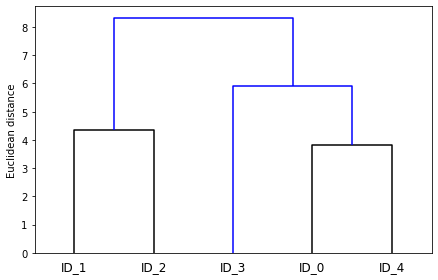

In [60]:
# 덴드로그램으로 연결행렬 시각화하기 

from scipy.cluster.hierarchy import dendrogram

# 검은색 덴드로그램 만들기 (1/2 부분만)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters,
                       labels = labels,
                       # 검은색 덴드로그램 만들기 (2/2 부분)
                       # color_threshold = np.inf
                       )

plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

# 병합 계층 군집으로 만들어지는 클러스터들을 요약
# 높이가 낮을 수록 유클리디안 거리 기반 가장 가까운 샘플

### 11.2.3 히트맵에 덴드로그램 연결하기

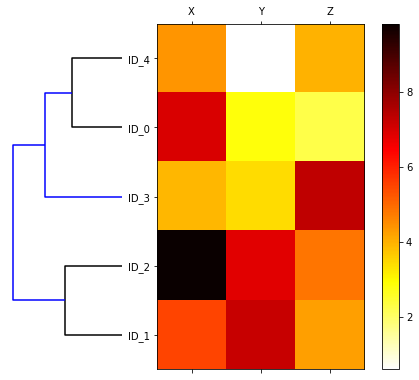

In [64]:
fig = plt.figure(figsize = (8, 8), facecolor = 'white') #figure 객체 생성
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6]) # 덴드로그램 형태 지정
row_dendr = dendrogram(row_clusters, orientation = 'left') # 반시계 방향으로 회전

# 군집에 맞게 데이터를 재정렬
df_rowclust = df.iloc[row_dendr['leaves'][:: -1]]

# 히트맵을 출력
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6]) # x-위치, y-위치, 너비, 높이
cax = axm.matshow(df_rowclust, 
                  interpolation = 'nearest', cmap = 'hot_r')

# 덴드로그램의 축 제거, 그래프 테두리 감추기, 컬러막대 추가, 레이블 할당
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)

fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))
plt.show()

# 히트맵의 행 순서는 덴드로그램 샘플 군집을 반영

### 11.2.4 사이킷런에서 병합 군집 적용하기

In [0]:
# 사이킷런 클래스를 이용하여 병합 계층 군집 수행

from sklearn.cluster import AgglomerativeClustering

# 위의 설정과 같은 방식 사용
ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('클러스터 레이블: %s' % labels)

# 결과는 덴드로그램과 동일하게 ID0, ID4가 1번 군집, ID2, ID3이 0번 군집, ID3은 자기자신(2번)으로 할당되었음

클러스터 레이블: [1 0 0 2 1]


In [0]:
# ID3에 대해 [ID0, ID4] 와 [ID2, ID3] 중 더 거리가 가까운 군집을 찾기 위해 군집 개수를 2로 줄임
ac = AgglomerativeClustering(n_clusters=2, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('클러스터 레이블: %s' % labels)

# [ID0, ID4]와 같은 클러스터로 묶임을 확인

클러스터 레이블: [0 1 1 0 0]
